> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [NO_SHOW-APP]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## No show up dataset

### Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row of dataset.

List of No-show appointments data set columns

PatientId
AppointmentID
Gender	
ScheduledDay	
AppointmentDay	
Age	
Neighbourhood	
Scholarship	
Hipertension	
Diabetes	
Alcoholism	
Handcap	
SMS_received	
No-show


## Questions

### Question 1: 
    What's the rate of showing by genders?
### Question 2
    What's the rate of showing for patients who has scolarships?
### Question 3
    What's the rate of showing up by Neighbourhood?
### Question 4
    What's the rate of showing up for patients who has Diabetes?
### Question 5
     What's the rate of showing up for patients who has Diabetes and over age?
### Question 6
     What's the rate of showing up for patients who has not recieved SMS?


In [4]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

# NOUR OMAR: 1. Read dataset
#            2. remove unused columns (PatientId,AppointmentID ,Handcap,Hipertension,ScheduledDay,AppointmentDay)

            


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


In [274]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.


In [5]:
# NOUR OMAR: 1. Read dataset
#            2. remove unused columns (PatientId,AppointmentID ,Handcap,Hipertension,ScheduledDay,AppointmentDay)
#            3. Change column name "No-show" to "No_show"
#            4. Change No_show column values to lower case

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:

df.drop(['PatientId', 'AppointmentID', 'Handcap', 'Hipertension','ScheduledDay','AppointmentDay'], axis = 1, inplace = True)
df.drop(['Neighbourhood'], axis = 1, inplace = True)
df.head()


,Gender,Age,Scholarship,Diabetes,Alcoholism,SMS_received,No-show
0,F,62,0,0,0,0,No
1,M,56,0,0,0,0,No
2,F,62,0,0,0,0,No
3,F,8,0,0,0,0,No
4,F,56,0,1,0,0,No


In [7]:

df.head()
df.rename(columns={'No-show': 'No_show'}, inplace = True)
df.head()
df['No_show'] = df['No_show'].str.lower()
df.head()

,Gender,Age,Scholarship,Diabetes,Alcoholism,SMS_received,No_show
0,F,62,0,0,0,0,no
1,M,56,0,0,0,0,no
2,F,62,0,0,0,0,no
3,F,8,0,0,0,0,no
4,F,56,0,1,0,0,no


<a id='eda'></a>
## Exploratory Data Analysis
### Research Question 1 What's the rate of showing for genders?

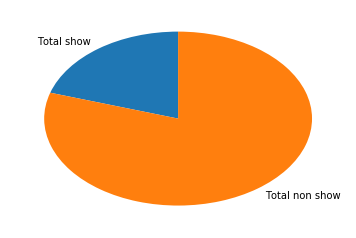

In [8]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

# NOUR OMAR: Solve Q1: Whhat's the rate of showing/non showing by genders?
#                      Will draw pie chart with showed up to non showed up rate
#                      Will calculate the non showed up males / total males reservations
#                      Will calculate the non showed up females / total females reservations

# Will calculate the non showed up / total reservations

tot = df.shape
tot = int(tot[0])

tot_non_show = df.query('No_show == "no"').shape
tot_non_show = int(tot_non_show[0])
tot_show  = tot -tot_non_show 


y = np.array([tot_show,tot_non_show])
mylabels = ["Total show","Total non show"]

plt.pie(y, labels = mylabels, startangle = 90)

plt.show()

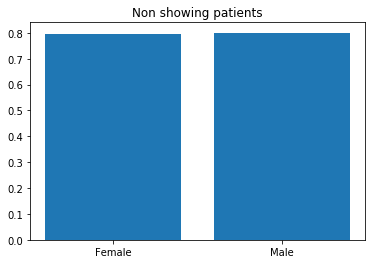

In [9]:


# Will calculate the non showed up males / total males reservations

tot_m = df.query('Gender == "M"').shape
tot_m = int(tot_m[0])

tot_non_m = df.query('Gender == "M" and No_show == "no"' ).shape
tot_non_m = int(tot_non_m[0])

tot_ratio_m = tot_non_m / tot_m


# Will calculate the non showed up females / total females reservations


tot_f = df.query('Gender == "F"').shape
tot_f = int(tot_f[0])

tot_non_f = df.query('Gender == "F" and No_show == "no"' ).shape
tot_non_f = int(tot_non_f[0])
tot_ratio_f = tot_non_f / tot_f


# creating the bar plot

x = [tot_ratio_f,tot_ratio_m]
y = ['Female','Male']

plt.bar(y,x)
 
plt.title("Non showing patients")
plt.show()

### Research Question 2   What's the rate of showing for patients who has scolarships?

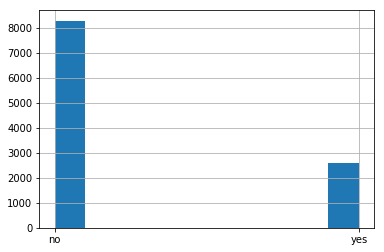

In [10]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.

# NOUR OMAR: Solve Q2: What's the rate of showing for patients who has scolarships?

df.query('Scholarship == "1"')['No_show'].hist();


### Research Question 3  What's the rate of showing up for patients who has Diabetes by gender?

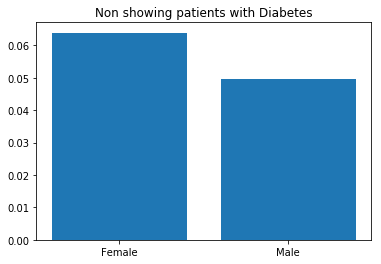

In [11]:

# Will calculate the non showed up males / total males reservations

tot_m = df.query('Gender == "M"').shape
tot_m = int(tot_m[0])

# Will calculate the non showed up males with Diabetes / total males reservations

tot_non_m = df.query('Gender == "M" and Diabetes == "1" and No_show == "no"').shape
tot_non_m = int(tot_non_m[0])

tot_ratio_m = tot_non_m / tot_m


# Will calculate the non showed up females / total females reservations


tot_f = df.query('Gender == "F"').shape
tot_f = int(tot_f[0])



tot_non_f = df.query('Gender == "F" and Diabetes == "1" and No_show == "no"').shape
tot_non_f = int(tot_non_f[0])
tot_ratio_f = tot_non_f / tot_f


# creating the bar plot

x = [tot_ratio_f,tot_ratio_m]
y = ['Female','Male']

plt.bar(y,x)
 
plt.title("Non showing patients with Diabetes");

### Research Question 4  What's the rate of non - showing up for patients whose over mid age by gender?

38.893986637
(29563, 7)


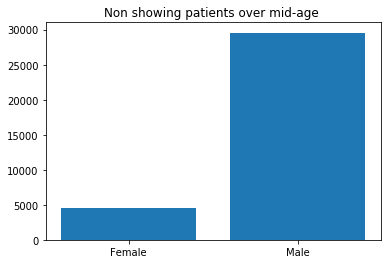

In [12]:

# Will calculate the non showed up males / total males reservations

tot_m = df.query('Gender == "M"').shape
tot_m = int(tot_m[0])

# Will calculate mean of age on males

m_mean = df.query('Gender == "M"')['Age'].mean()
m_mean = str(m_mean)
# Will calculate the non showed up males / total males reservations

tot_non_m = df.query('Gender == "M" and No_show == "no"')


tot_non_m = tot_non_m.query('Age > '+m_mean).shape
tot_non_m = int(tot_non_m[0])


# Will calculate the non showed up females / total females reservations

tot_f = df.query('Gender == "F"').shape
tot_f = int(tot_f[0])

# Will calculate mean of age on females

f_mean = df.query('Gender == "F"')['Age'].mean()
f_mean = str(f_mean)
print(f_mean)


# Will calculate the non showed up females / total females reservations

tot_non_m = df.query('Gender == "F" and No_show == "no"')


tot_non_m = tot_non_m.query('Age > '+f_mean).shape
print(tot_non_m)
tot_non_m = int(tot_non_m[0])

#creating the bar plot

x = [tot_non_f,tot_non_m]
y = ['Female','Male']

plt.bar(y,x)
 
plt.title("Non showing patients over mid-age ");



### Research Question 5 What's the rate of showing up for patients who has not recieved SMS?

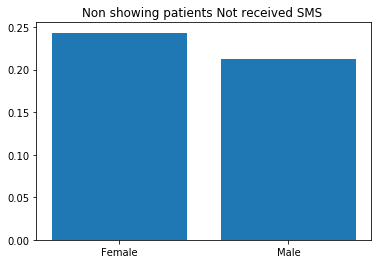

In [13]:

# Will calculate the non showed up males / total males reservations

tot_m = df.query('Gender == "M"').shape
tot_m = int(tot_m[0])

# Will calculate the non showed up males with Diabetes / total males reservations

tot_non_m = df.query('Gender == "M" and SMS_received == "1" and No_show == "no"' ).shape
tot_non_m = int(tot_non_m[0])

tot_ratio_m = tot_non_m / tot_m


# Will calculate the non showed up females / total females reservations


tot_f = df.query('Gender == "F"').shape
tot_f = int(tot_f[0])



tot_non_f = df.query('Gender == "F" and SMS_received == "1" and No_show == "no"').shape
tot_non_f = int(tot_non_f[0])
tot_ratio_f = tot_non_f / tot_f


# creating the bar plot

x = [tot_ratio_f,tot_ratio_m]
y = ['Female','Male']

plt.bar(y,x)
 
plt.title("Non showing patients Not received SMS ");

<a id='conclusions'></a>
## Conclusions

Ratio for males who not showing up from total reserved men so close to the ratio of non showing females to total reserved females

Patients who has no Scholarship not showing more than the patients who has Scholarship 

Females patients who has diabetes showing less than the males who has diabetes

Males over age showing less than women that over age 

Females who not received SMS showing less than the men


### Limitations

Need to have more data of patients in order to have better analysis


## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [14]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0